using embeddings to convert words into a T x D matrix of numbers<br>
** read about word3vec and GloVe

<ol>
<li>Convert words into integers (indices into the word embedding matrix)</li>
<li>Mapping from words to integer</li>
<li>integers start from 1 not 0 because 0 is used for padding</li>
<li>convert strings to sequences</li>
<li>Tokenize: each string is a single word</li>
<li>The process is string to tokens to integers to vectors</li>
<li>Padding: to make sequences the same length</li>
<li>N is the number of lists of integers</li>
<li>T is the length of the sequence</li>
<li>Truncating pre or post</li>
<li>Padding: pre or post</li>
</ol>

We have an N x T matrix of word indices. When passed by the embedding layer, we get N x T x D tensor converting it into a word vector. 

In [72]:
# preprocessing text
import csv
from nltk.corpus import stopwords
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
plt.style.use('fivethirtyeight')


In [5]:
# using list of stop words to remove from text
stop_words = stopwords.words("english")
print(len(stop_words))

153


In [6]:
# preprocessing text
texts = []
labels = []
# reading the data. 
# for each row, the first item is the label
with open('data/bbc-text.csv','r') as file: # reading the files
    data = csv.reader(file)
    next(data, None)
    for row in data:
        labels.append(row[0])
        sentence = row[1]
        for word in stop_words: # replacing tokens with an empty space, and then replacing double space with a single space
            token = ' ' + word + ' '
            sentence = sentence.replace(token,' ')
            sentence = sentence.replace('  ', ' ')
        texts.append(sentence)

        
print(len(labels))
print(len(texts))


2225
2225


In [45]:
MAX_VOCAB_SIZE = 10000
# out of words token
oov_tok = '<OOV>'
# padding
padding_type = 'post'
trunc_type = 'post'
max_len = 120

# splitting data into train and validation
training_size = int(np.ceil(0.8 * len(texts)))
X_train, X_valid = texts[:training_size], texts[training_size:]
y_train, y_valid = labels[:training_size], labels[training_size:]

tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
# a dictionary of words as key and integer as value
word_index = tokenizer.word_index
V = len(word_index)
print(f"There are {V} unique tokens")
# convert to sequences
sequences = tokenizer.texts_to_sequences(X_train)
# padding
padded = pad_sequences(sequences, maxlen=max_len ,truncating=trunc_type, padding=trunc_type)
print(f"Shape of padded sequences: {padded.shape}")

valid_seq = tokenizer.texts_to_sequences(X_valid)
valid_padded = pad_sequences(valid_seq, maxlen=max_len, padding=padding_type, truncating=trunc_type)
print(f"Validation data shape: {valid_padded.shape}")

There are 27269 unique tokens
Shape of padded sequences: (1780, 120)
Validation data shape: (445, 120)


In [42]:
# tokenizing labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y_train)
label_index = label_tokenizer.word_index
print(label_index)
label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
print(label_seq.shape)
valid_label_seq = np.array(label_tokenizer.texts_to_sequences(y_valid))
print(valid_label_seq.shape)



{'sport': 1, 'business': 2, 'politics': 3, 'entertainment': 4, 'tech': 5}
(1780, 1)
(445, 1)


In [56]:
valid_label_seq.shape

(445, 1)

# Modeling

In [61]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, GlobalMaxPool1D, Dense
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.models import Model

In [ ]:
model = tf.keras.Sequential([
    Embedding(MAX_VOCAB_SIZE,D,input_length=max_len), # embedding layer
    GlobalAveragePooling1D(), # used to flatten the input into the next layer
    Dense(24, activation='relu'), # a dense layer with 24 neurons
    Dense(6, activation='softmax') # output layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [68]:
# model

# embedding dimensions
T = max_len
D = 16
M = 24 # hidden state dimensions
O = 6
i = Input(shape=(T,)) # input layer
# size of embedding is V+1 because index starts from 1 instead of 0
# If the final index of the embedding matrix is V, then it must have size V+1
x = Embedding(V +1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(O, activation='sigmoid')(x)

model = Model(i,x)
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 120, 16)           436320    
_________________________________________________________________
lstm_5 (LSTM)                (None, 120, 24)           3936      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 24)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 150       
Total params: 440,406
Trainable params: 440,406
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [70]:
EPOCHS = 50
r = model.fit(padded, label_seq, epochs=EPOCHS,
validation_data=(valid_padded, valid_label_seq))

Epoch 1/50
56/56 [==============================] - 3s 59ms/step - loss: 1.7537 - accuracy: 0.2343 - val_loss: 1.6651 - val_accuracy: 0.2472
Epoch 2/50
56/56 [==============================] - 3s 47ms/step - loss: 1.6514 - accuracy: 0.2270 - val_loss: 1.6202 - val_accuracy: 0.3213
Epoch 3/50
56/56 [==============================] - 3s 49ms/step - loss: 1.6139 - accuracy: 0.2534 - val_loss: 1.5946 - val_accuracy: 0.2292
Epoch 4/50
56/56 [==============================] - 3s 47ms/step - loss: 1.5222 - accuracy: 0.3994 - val_loss: 1.7224 - val_accuracy: 0.2022
Epoch 5/50
56/56 [==============================] - 3s 59ms/step - loss: 1.4662 - accuracy: 0.3551 - val_loss: 1.3673 - val_accuracy: 0.4315
Epoch 6/50
56/56 [==============================] - 3s 48ms/step - loss: 1.2769 - accuracy: 0.4567 - val_loss: 1.2704 - val_accuracy: 0.4629
Epoch 7/50
56/56 [==============================] - 3s 48ms/step - loss: 1.1741 - accuracy: 0.5331 - val_loss: 1.2032 - val_accuracy: 0.4966
Epoch 8/50
56

In [71]:
def plot_metrics(history, string):
    plt.figure(figsize=(12,7))
    plt.plot(history.history[string], label=string)
    plt.plot(history.history['val_'+string], label='val_'+string)
    plt.xlabel('Epochs')
    plt.ylabel(string.title())
    plt.legend(loc=5)
    plt.title(f'Training & Validation {string.title()}', fontsize=14)
    plt.show()

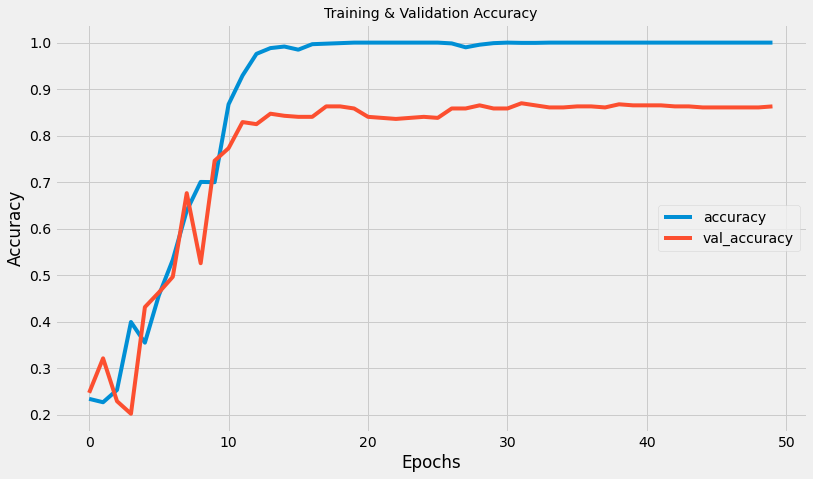

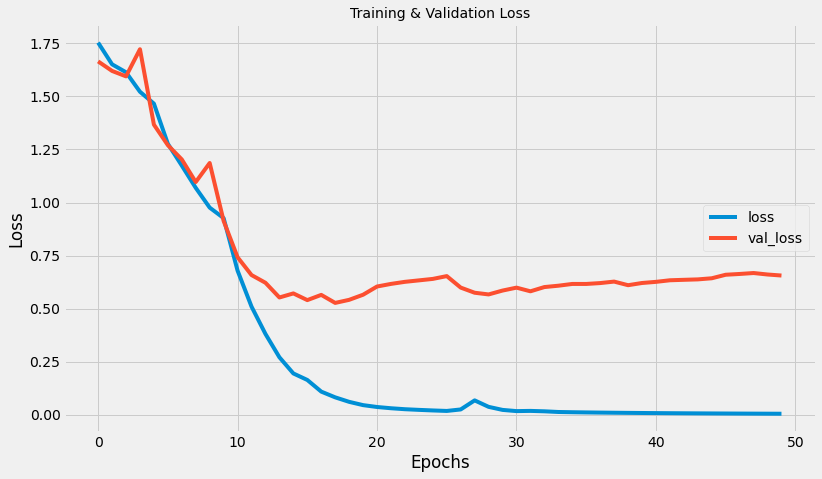

In [73]:
plot_metrics(r,'accuracy')
plot_metrics(r,'loss')

In [79]:
# get weights 
# get embedding layer 


e = model.layers[1]
weights = e.get_weights()[0]
print(weights.shape)


(27270, 16)


In [80]:
reverse_word_index = dict([(value,key) for key,value in word_index.items()])

# saving vecs and meta
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, MAX_VOCAB_SIZE):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word+'\n')
    out_v.write('\t'.join([str(x) for x in embeddings])+'\n')

out_v.close()
out_m.close()